<b>[Authors]</b> Aljoša Smajić & Melanie Grandits & Fabian Kaiser
<br><b>[Organisation]</b> UNIVIE
<br><b>[Group]</b> Pharmacoinformatics Research Group
<br><b>[Year]</b> 2022

# UNIVIE ChEMBL Query Jupyter Notebook (JN) via CSV

<b>How to use this JN? 

This JN enables the user to retrieve data from ChEMBL. The data can be requested via a SQL query by adding the target ID using a CSV-file, ChEMBL release version and activity threshold in the cell code indicated with a star at the end of the heading.
    
It can be executed by pushing the "Run ALL" button, once the requested information is added to the corresponding text fields indicated with a star at the heading:"<b> Please enter the name of your csv-file containing your ChEMBL IDs, the desired ChEMBL release, activity threshold and click on 'Run All Below"
   
 **Please run the first three cell codes to activate the libraries, display the RDKit Version/Pandas Version and the search field taskbars. Once the information is added to the JN in the search fields click on the button "Run All". **
    
<b>The JN is divided into four parts:
     
    • Connect to Postgress
    • Query Data
    • Data Filtering
    • Disconnect to Postgress
The individual steps are described by the headings found above each cell code and the resulted data frame is saved as a SDF-file and CSV-file.
    

If more than 40 targets are within your csv-file, please open your jupyter notebook using the following command to set a new data rate limit:

jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
    
This will prevent your JN from crushing down.
    
    
    
For further information don't hesitate to contact: aljosa.smajic@univie.ac.at

In [1]:
import psycopg2
import pandas as pd
import numpy as np

from IPython.display import Javascript, display
import ipywidgets as widgets
from ipywidgets import interact, Dropdown,Button

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem import PandasTools as PandasTools

from molvs import Standardizer
from molvs.errors import MolVSError

from pandarallel import pandarallel as para

import sklearn

from IPython.core.display import HTML

<b>The versions of the pkgs are displayed

In [2]:
# Displays the version used in this JN
print(" RDKit Version " + rdkit.__version__ + " is used.")
print(" Pandas Version " + pd.__version__ + " is used.")
pd.set_option('display.max_colwidth', None)
PandasTools.RenderImagesInAllDataFrames(images=True)
para.initialize(progress_bar=True)

 RDKit Version 2022.03.2 is used.
 Pandas Version 1.3.5 is used.
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Please add the target, the ChEMBL release and the threshold for the classifcation*

In [3]:
# Interactive tool that enables the user to search, and save the desired information in facile manner via taskbars/searchbars 
class date_input():
    def __init__(self,
                 file_name = ".csv",
                 chembl_release = "chembl_31", 
                 threshold = "5"
                ):
        self.file_name = widgets.Text(description = 'file_name',value = file_name)            
        self.chembl_release = widgets.Text(description = 'release',value = chembl_release)    
        self.threshold = widgets.Text(description = 'threshold',value = threshold)    

        self.file_name.on_submit(self.handle_submit)
        self.chembl_release.on_submit(self.handle_submit)
        self.threshold.on_submit(self.handle_submit)
        
        display(self.file_name, self.chembl_release, self.threshold)

    def handle_submit(self, text):
        self.v = text.value
        return self.v

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

    
print("Please enter the name of your csv-file containing your ChEMBL IDs, the desired ChEMBL release, activity threshold and click on 'Run All Below'")
f = date_input()

# Runs the whole JN by pushing the "Run all" button
button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

Please enter the name of your csv-file containing your ChEMBL IDs, the desired ChEMBL release, activity threshold and click on 'Run All Below'


Text(value='.csv', description='file_name')

Text(value='chembl_31', description='release')

Text(value='5', description='threshold')

Button(description='Run all below', style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
df_csv = pd.read_csv(f.file_name.value, index_col=False)

In [52]:
# checks if the compound is organic or inorganic
def is_nonorganic(fragment):
    """Return true if fragment contains at least one carbon atom.
    :param fragment: The fragment as an RDKit Mol object.
    """
    # adapted from MolVS function is_organic!!
    # Could allow only H, C, N, O, S, P, F, Cl, Br, I
    for a in fragment.GetAtoms():
        if a.GetAtomicNum() == 6:
            return False
    return True

# checks if the retrieved compound has non-organic fragments
def contains_nonorg(fragment):
    # organic: H, C, N, O, P, S, F, Cl, Br, I
    for a in fragment.GetAtoms():
        if a.GetAtomicNum() not in [1, 6, 7, 8, 15, 16, 9, 17, 35, 53]:
            return "Yes"
    return "No"

# standardisation, fragment removal, uncharge molecules, remove stereochemistry
def standardise_remove_fragments_uncharge_removesteochemistry(df):
    # adds the molvs standardizer as a variable
    s = Standardizer()
    # checks if contains non organic fragment
    fragment_nonorganic = df['ROMol'].parallel_apply(lambda x:contains_nonorg(x))
    df = df.assign(fragment_nonorganic=fragment_nonorganic)
    # standardizes each compound
    ROMol_stand = df['ROMol'].parallel_apply(lambda x:s.standardize(x))
    df = df.assign(ROMol_stand=ROMol_stand)    
    # removes fragments from each compound using molvs
    ROMol_frag = df['ROMol_stand'].parallel_apply(lambda x:s.remove_fragments(x))
    df = df.assign(ROMol_frag=ROMol_frag)
    # keeps the larger fragment in each compound 
    ROMol_frag2 = df['ROMol_stand'].parallel_apply(lambda x:s.largest_fragment(x))
    df = df.assign(ROMol_frag2=ROMol_frag2)
    # removes stereochemistry in each compound
    ROMol_stereo = df['ROMol_frag2'].parallel_apply(lambda x:s.stereo_parent(x))
    df = df.assign(ROMol_stereo=ROMol_stereo)
    # removes the charges from each compounds    
    ROMol_charge = df['ROMol_stereo'].parallel_apply(lambda x:s.uncharge(x))
    df = df.assign(ROMol_charge=ROMol_charge)
    # checks if molecule is organic or inorganic
    inorganic = df['ROMol_charge'].parallel_apply(lambda x:is_nonorganic(x))
    df = df.assign(inorganic=inorganic)
    # adds a column with the final ROMol formate
    df = df.assign(ROMol_fin=ROMol_charge)
    return(df)

# calculates the InChIs, SMILES, InChIKeys
def calc_InCHI_SMILES_InChIKey(df):
    # calculates InChIs for each standarized compound
    InChIs_stand = df['ROMol_fin'].parallel_apply(lambda x:AllChem.MolToInchi(x))
    df = df.assign(InChIs_stand=InChIs_stand)
    # calculates SMILES for each standarized compound
    SMILES_stand = df['ROMol_fin'].parallel_apply(lambda x:AllChem.MolToSmiles(x))
    df = df.assign(SMILES_stand=SMILES_stand)
    # calculates InChIkeys for each compound
    InChIKey_stand = df['ROMol_fin'].parallel_apply(lambda x:AllChem.MolToInchiKey(x))
    df = df.assign(InChIKey_stand=InChIKey_stand)
    return(df)

# removes stereochemistry information
def removeStereoInfo_from_InChI(fullInchi, position, delimiter):
    return delimiter.join(fullInchi.split(delimiter)[:position])

# used to identify molerror during standardisation
def molerror(mol):
    # gives an error if a problem occurs
    err = MolVSError()
    try:
        return err.with_traceback(mol)
    except:
        pass

# removes compounds with non overlapping classification values        
def remove_classerror(x):
        if x in df_classerror:
            df_classerror.remove(x)
            return False
        return True
    
# removes compounds with non overlapping classification values    
def rem_class(df1,df2):
    if len(df1.index) == 0:
        print('No duplicates found.')
    else:
        Comparison_dupl = df1[['ROMol','Classification','InChI_steorem']]
        Comparison_uniq = df2[['ROMol','Classification','InChI_steorem']]
        merged   =    pd.merge(
                      left=Comparison_dupl,
                      right=Comparison_uniq,
                      how="left",
                      left_on="InChI_steorem",
                      right_on="InChI_steorem")
        merged['Class_Match'] = merged.apply(lambda x : str(x.Classification_x) in str(x.Classification_y), axis=1)
        Non_Matching_Class = merged.loc[merged['Class_Match'] == False]
        df_classerror = Non_Matching_Class['InChI_steorem'].tolist()
        df2 = df2[~df2.InChI_steorem.isin(df_classerror)]
        print('Compounds with classification mismatch removed.')
    return (df2)

### Connect to Postgres

In [53]:
connection = psycopg2.connect(user="chembl",
                                  password="chembl",
                                  host="horus.pch.univie.ac.at",
                                  port="5432",
                                  database=f.chembl_release.value)   #Version of the database can be changed here. Just change the number to 24/25/...
cursor = connection.cursor()

### Query Data

In [54]:
# Edited by Aljoša Smajić & Melanie Grandits & Fabian Kaiser
# Example Querys can be found here: https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/schema-questions-and-sql-examples
# In this case the DB is searched by a CHEMBL-ID and the columns molfile, chembl_id, ... are requested.
# This example was tested for chembl 24-31.

var = [f"'{i}'" for i in df_csv['CHEMBL_ID']]
ids = tuple(var)
item_placeholders = ','.join(ids)# * len(ids))
# placeholder = '%s'
# placeholders= ','.join(placeholder for i in ids)


query=(f"""SELECT DISTINCT
  s.molfile AS molecule,
  m.chembl_id					AS compound_chembl_id,
  a.assay_id					AS assay_id,
  act.pchembl_value				AS pchembl,
  act.standard_type				AS standard_type,
  act.standard_relation			AS standard_relation,
  act.standard_value			AS standard_value,
  act.standard_units			AS standard_units,
  t.chembl_id					AS target_chembl_id,
  t.pref_name					AS target_name,
  r.compound_key				AS compound_key,
  t.organism					AS target_organism,
  a.description					AS assay_description,
  a.assay_type					As assay_type,
  act.data_validity_comment		AS data_validity_comment,
  act.activity_comment			AS activity_comment,
  t.target_type					AS target_type,
  r.doc_id						AS doc_id,
  r.record_id					AS record_id,
  a.tid							AS tid,
  a.confidence_score			AS confidence_score,
  d.doi							AS doi,
  a.relationship_type			AS relationship_type,
  d.year						AS year,
  a.bao_format					AS bao_format 
FROM compound_structures s
  RIGHT JOIN molecule_dictionary m ON s.molregno = m.molregno
  JOIN compound_records r ON m.molregno = r.molregno
  JOIN docs d ON r.doc_id = d.doc_id
  JOIN activities act ON r.record_id = act.record_id
  JOIN assays a ON act.assay_id = a.assay_id
  JOIN target_dictionary t ON a.tid = t.tid
  JOIN target_components tc ON t.tid = tc.tid
  JOIN component_sequences cs ON tc.component_id = cs.component_id
    AND t.chembl_id in ({item_placeholders});""")

cursor.execute(query, ids)

### Collect Data as Pandas Dataframe

In [55]:
result = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
df = pd.DataFrame(result, columns=colnames)

In [56]:
print (str(len(df)) + ' compounds have been found for your target in the selected ChEMBL release.')

2449 compounds have been found for your target in the selected ChEMBL release.


### Data Filtering (for correct pchembl)

In [57]:
# Filter out "missing" pchembl
df_filt1 = df.dropna(subset=['pchembl'])

# Filter for "missing" pchembl
df_miss = df.loc[~df['pchembl'].isin(df['pchembl'].dropna())]

print (str(len(df_filt1)) + ' compounds without missing pchembl values.')
print (str(len(df_miss)) + ' compounds with missing pchembl values.')

685 compounds without missing pchembl values.
1764 compounds with missing pchembl values.


#### Filter out "NaN"

In [58]:
# Filter out "NaN" pchembl
df_filt2 = df_filt1.loc[~df_filt1['pchembl'].isin(df_filt1['pchembl'].isnull())]

# Filter for "NaN" pchembl
df_nan = df_filt1[df_filt1['pchembl'].isnull()]

print (str(len(df_filt2)) + ' compounds do not contain "NaN" within the pchembl column.')
print (str(len(df_nan)) + ' compounds contain "NaN" within the pchembl column.')

685 compounds do not contain "NaN" within the pchembl column.
0 compounds contain "NaN" within the pchembl column.


#### Filter out pchembl activity value = 0

In [59]:
# Filter out pchembl entries with activity value = 0
df_filt3 = df_filt2.loc[~(df_filt2['pchembl']==0)]

# Filter for pchembl entries with activity value = 0
df_zero = df_filt2.loc[(df_filt2['pchembl']==0)]

print (str(len(df_filt3)) + ' compounds have no activity value of zero.')
print (str(len(df_zero)) + ' compounds have an activity value of zero.')

685 compounds have no activity value of zero.
0 compounds have an activity value of zero.


#### Filter out "negative" pchembl entries

In [60]:
# Filter out "negative" pchembl entries
df_filt4 = df_filt3[~(df_filt3[['pchembl']] < 0).all(1)]

# Filter out "negative" pchembl entries
df_neg = df[(df[['pchembl']] < 0).all(1)]

print (str(len(df_filt4)) + ' compounds have no negative pchembl value entry.')
print (str(len(df_neg)) + ' compounds have an negative pcheml value entry.')

685 compounds have no negative pchembl value entry.
0 compounds have an negative pcheml value entry.


#### Keep only compounds with standard relation equals '='

In [61]:
# Keep only the compounds with equal sign in column standard_relation
df_filt5  = df_filt4.loc[df_filt4['standard_relation'] == '=']

# Filter out compounds without equal sign
df_unequal  = df.loc[~(df['standard_relation'] == '=')]

print (str(len(df_filt5)) + ' compounds with equal sign.')
print (str(len(df_unequal)) + ' compounds contain no equal sign.')

685 compounds with equal sign.
1250 compounds contain no equal sign.


#### Display size of compounds only with IC50 & Ki values 

In [62]:
# Display how many IC50 & Ki values present
df_IC50_values  = df_filt5.loc[df_filt5['standard_type'] == 'IC50']
df_Ki_values = df_filt5.loc[df_filt5['standard_type'] == 'Ki']
print (str(len(df_IC50_values)) + ' compounds with IC50 been found in ChEMBL release.')
print (str(len(df_Ki_values)) + ' compounds with Ki been found in ChEMBL release.')

678 compounds with IC50 been found in ChEMBL release.
7 compounds with Ki been found in ChEMBL release.


#### Create new dataframe with only IC50 or Ki values

In [63]:
# Creates df with compounds containing only IC50 or Ki 
df_IC50_Ki = df_filt5.loc[df_filt5['standard_type'].isin(['IC50', 'Ki'])]
print (str(len(df_IC50_Ki)) + ' compounds with IC50 & Ki value found in '+ f.chembl_release.value)

685 compounds with IC50 & Ki value found in chembl_31


In [64]:
# Threshold calculation
Classification = np.where(df_IC50_Ki['pchembl'] < int(f.threshold.value), 0, 1)
df_IC50_Ki = df_IC50_Ki.assign(Classification=Classification)

In [65]:
# Removes emptycompounds with an empty molecule entry
df_IC50_Ki = df_IC50_Ki.dropna(subset=['molecule'])

In [66]:
# Creates the ROMol Format and corresponding column
ROMol = df_IC50_Ki['molecule'].map(lambda x:AllChem.MolFromMolBlock(x))
df_IC50_Ki = df_IC50_Ki.assign(ROMol=ROMol)

In [67]:
# Drop column 'molecule' since causes problems when creating an SDF-file later on
df_IC50_Ki = df_IC50_Ki.drop(columns=['molecule'])

In [68]:
print (str(len(df_IC50_Ki)) + ' compounds found in ' + f.chembl_release.value + ' and can be saved as a SDF-file & CSV-file.')

685 compounds found in chembl_31 and can be saved as a SDF-file & CSV-file.


#### Standardization

The standardization procedures includes a tool to parallelize the computation on all your CPUs indicated by the bar charts.

In [69]:
# Compounds are standarised
molecules_stand = standardise_remove_fragments_uncharge_removesteochemistry(df_IC50_Ki)

#### Drop columns with inorganic compounds

In [70]:
# Checks if compounds are inorganic
molecules_organic = molecules_stand[molecules_stand['inorganic'] == False]
molecules_organic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 1 to 2446
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   compound_chembl_id     685 non-null    object
 1   assay_id               685 non-null    int64 
 2   pchembl                685 non-null    object
 3   standard_type          685 non-null    object
 4   standard_relation      685 non-null    object
 5   standard_value         685 non-null    object
 6   standard_units         685 non-null    object
 7   target_chembl_id       685 non-null    object
 8   target_name            685 non-null    object
 9   compound_key           685 non-null    object
 10  target_organism        685 non-null    object
 11  assay_description      685 non-null    object
 12  assay_type             685 non-null    object
 13  data_validity_comment  2 non-null      object
 14  activity_comment       26 non-null     object
 15  target_type           

#### Calculation of InChIs, SMILES and InChIKeys

The caclulation of InChIs, SMILES and InChIKeys includes a tool to parallelize the computation on all your CPUs indicated by the bar charts.

In [71]:
# Calculation of InChIs, SMILES and InChIKeys
molecules_organic = calc_InCHI_SMILES_InChIKey(molecules_organic)

[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Charges were rearranged; Omitted undefined stereo


[11:56:57] WARNING: Charges were rearranged


[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo



[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Charges were rearranged




[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo




[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] W


[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Charges were rearranged; Omitted undefined stereo




[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Charges were rearranged; Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo



[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo



[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted

[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo



[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo



[11:56:57] WARNING: Omitted undefined stereo

[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo
[11:56:57] WARNING: Omitted undefined stereo


[11:56:57] WARNING: Omitted undefi

#### Removal of Steroechemistry in InChI for Duplicate Check

In [72]:
# Removal of stereochemistry from InChIs
molecules_organic['InChI_steorem'] = molecules_organic['InChIs_stand'].map(lambda x:removeStereoInfo_from_InChI(x,4,"/"))

#### Standardisation Check

The standardization check includes a tool to parallelize the computation on all your CPUs indicated by the bar charts.

In [73]:
# Standardisation Check
molecules_organic['molerror'] = pd.DataFrame(molecules_organic['ROMol_fin'].parallel_apply(lambda x:molerror(x)))
molecules_error = molecules_organic[~molecules_organic['molerror'].isnull()]
molecules_non_error = molecules_organic[molecules_organic['molerror'].isnull()]

The first 5 compounds of the dataframe are displayed after data filtration & standardization.

,compound_chembl_id,assay_id,pchembl,standard_type,standard_relation,standard_value,standard_units,target_chembl_id,target_name,compound_key,...,ROMol_frag2,ROMol_stereo,ROMol_charge,inorganic,ROMol_fin,InChIs_stand,SMILES_stand,InChIKey_stand,InChI_steorem,molerror
1,CHEMBL1123,1667662,4.40,IC50,=,40040.0,nM,CHEMBL6020,Bile salt export pump,Dicyclomine,...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","InChI=1S/C19H35NO2/c1-3-20(4-2)15-16-22-18(21)19(13-9-6-10-14-19)17-11-7-5-8-12-17/h17H,3-16H2,1-2H3",CCN(CC)CCOC(=O)C1(C2CCCCC2)CCCCC1,CURUTKGFNZGFSE-UHFFFAOYSA-N,"InChI=1S/C19H35NO2/c1-3-20(4-2)15-16-22-18(21)19(13-9-6-10-14-19)17-11-7-5-8-12-17/h17H,3-16H2,1-2H3",None
4,CHEMBL1726,1678644,4.48,IC50,=,33000.0,nM,CHEMBL6020,Bile salt export pump,Nisoldipine,...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","InChI=1S/C20H24N2O6/c1-11(2)10-28-20(24)17-13(4)21-12(3)16(19(23)27-5)18(17)14-8-6-7-9-15(14)22(25)26/h6-9,11,18,21H,10H2,1-5H3",COC(=O)C1=C(C)NC(C)=C(C(=O)OCC(C)C)C1c1ccccc1[N+](=O)[O-],VKQFCGNPDRICFG-UHFFFAOYSA-N,"InChI=1S/C20H24N2O6/c1-11(2)10-28-20(24)17-13(4)21-12(3)16(19(23)27-5)18(17)14-8-6-7-9-15(14)22(25)26/h6-9,11,18,21H,10H2,1-5H3",None
9,CHEMBL1201392,1667662,4.17,IC50,=,68460.0,nM,CHEMBL6020,Bile salt export pump,Flumetasone,...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","InChI=1S/C22H28F2O5/c1-11-6-13-14-8-16(23)15-7-12(26)4-5-19(15,2)21(14,24)17(27)9-20(13,3)22(11,29)18(28)10-25/h4-5,7,11,13-14,16-17,25,27,29H,6,8-10H2,1-3H3",CC1CC2C3CC(F)C4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO,WXURHACBFYSXBI-UHFFFAOYSA-N,"InChI=1S/C22H28F2O5/c1-11-6-13-14-8-16(23)15-7-12(26)4-5-19(15,2)21(14,24)17(27)9-20(13,3)22(11,29)18(28)10-25/h4-5,7,11,13-14,16-17,25,27,29H,6,8-10H2,1-3H3",None
15,CHEMBL1917041,788595,4.81,IC50,=,15488.17,nM,CHEMBL5205,GABA transporter 3,50,...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","InChI=1S/C25H27N5/c1-4-11-21(12-5-1)20-30-25(27-28-29-30)19-26-18-10-17-24(22-13-6-2-7-14-22)23-15-8-3-9-16-23/h1-9,11-16,24,26H,10,17-20H2",c1ccc(Cn2nnnc2CNCCCC(c2ccccc2)c2ccccc2)cc1,QPBUUMAIPFATEO-UHFFFAOYSA-N,"InChI=1S/C25H27N5/c1-4-11-21(12-5-1)20-30-25(27-28-29-30)19-26-18-10-17-24(22-13-6-2-7-14-22)23-15-8-3-9-16-23/h1-9,11-16,24,26H,10,17-20H2",None
16,CHEMBL451,1678644,4.36,IC50,=,44100.0,nM,CHEMBL6020,Bile salt export pump,Chlordiazepoxide,...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","InChI=1S/C16H14ClN3O/c1-18-15-10-20(21)16(11-5-3-2-4-6-11)13-9-12(17)7-8-14(13)19-15/h2-9H,10H2,1H3,(H,18,19)",CNC1=Nc2ccc(Cl)cc2C(c2ccccc2)=[N+]([O-])C1,ANTSCNMPPGJYLG-UHFFFAOYSA-N,"InChI=1S/C16H14ClN3O/c1-18-15-10-20(21)16(11-5-3-2-4-6-11)13-9-12(17)7-8-14(13)19-15/h2-9H,10H2,1H3,(H,18,19)",None

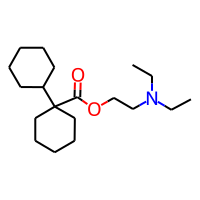
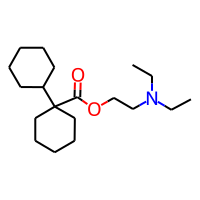
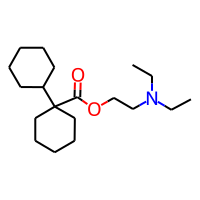
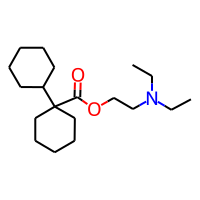
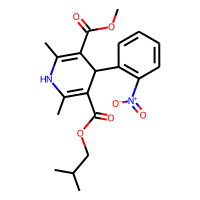
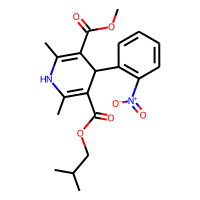
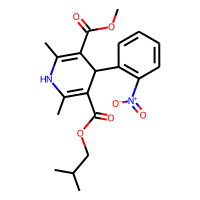
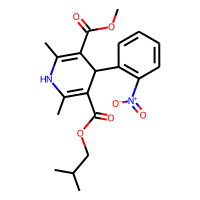
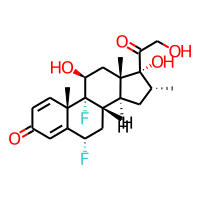
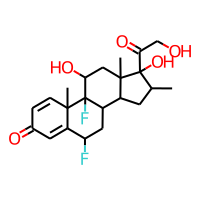
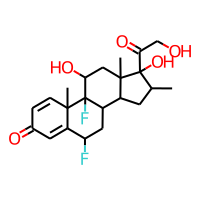
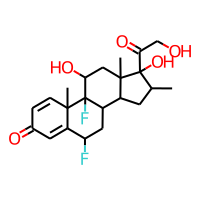
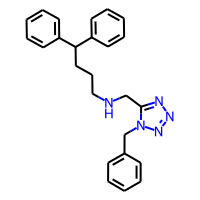
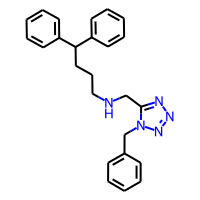
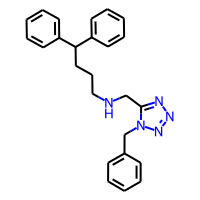
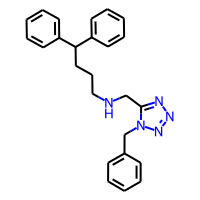
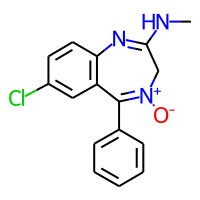
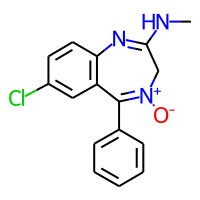
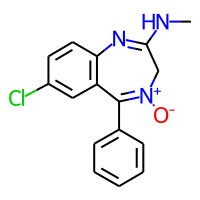
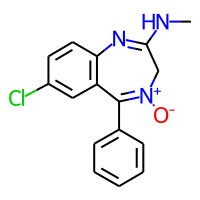

In [74]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs
molecules_organic.head()

#### Change Column Name ROMol_fin to ROMol and ROMol to ROMOl_init 

In [75]:
# Column name change 
SDF = molecules_organic.rename(columns = {'ROMol':'ROMol_init', 'ROMol_fin':'ROMol'}, inplace = True)

In [76]:
# Drops stepwise standardized ROMol formats
SDF = molecules_organic.drop(['ROMol_init','ROMol_stand','ROMol_frag','ROMol_frag2','ROMol_stereo','ROMol_charge'], axis=1)

The first 5 compounds of the dataframe are displayed for visualizing the structure of the dataframe.

In [77]:
SDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 1 to 2446
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   compound_chembl_id     685 non-null    object
 1   assay_id               685 non-null    int64 
 2   pchembl                685 non-null    object
 3   standard_type          685 non-null    object
 4   standard_relation      685 non-null    object
 5   standard_value         685 non-null    object
 6   standard_units         685 non-null    object
 7   target_chembl_id       685 non-null    object
 8   target_name            685 non-null    object
 9   compound_key           685 non-null    object
 10  target_organism        685 non-null    object
 11  assay_description      685 non-null    object
 12  assay_type             685 non-null    object
 13  data_validity_comment  2 non-null      object
 14  activity_comment       26 non-null     object
 15  target_type           

#### Removal of Duplicates in the Dataset, Classification Mismatch Check & Saves each DataSet as SDF- and CSV-file

In [78]:
# Groupby function for grouping based on target_chembl_id
grouped = SDF.groupby('target_chembl_id')

for name, group in grouped:
    group = group.drop_duplicates(subset='InChI_steorem',keep='first')
    group_dupl = group[group.duplicated(['InChI_steorem'], keep='first')]
    group = rem_class(group_dupl,group)
    PandasTools.WriteSDF(group,name+f.chembl_release.value+'.sdf',properties=list(group.columns))
    group.to_csv(name+f.chembl_release.value+'.csv',index=False)

No duplicates found.
No duplicates found.


### Disconnect from Postgres

In [79]:
# cursor.close()
# connection.close()